<h1> Capstone 2 Data Wrangling </h1><a id='Capstone_2_Data_Wrangling'></a>

## Table of Contents<a id='Table_of_Contents'></a>
* [1 Data Wrangling](#Capstone_2_Data_Wrangling)
    * [1.1. The Data Science Problem](#The_Data_Science_Problem)
        *  [1.1.1 Context](#Context)
        *  [1.1.2 Data Source Citation](#Data_Source_Citation)
 
    * [1.2 Imports](#Data_Imports)
        * [1.2.1 Import Libraries](#Import_Libraries)
        * [1.2.2 Import Data](#Import_Data)
            * [1.2.2.1 Read in train_v2.csv](#Read_in_train_v2.csv)
            * [1.2.2.2 Read in members_v3.csv](#Read_in_members_v3.csv)
            * [1.2.2.3 Read in transactions_v2.csv](#Read_in_transactions_v2.csv)
            * [1.2.2.4 Read in user_logs_v2.csv](#Read_in_user_logs_v2.csv)
            
    
* [1.3 Merging Dataframes](#Merging_Dataframes)
    * [1.3.1 Merge train_df and transactions_df: train_trans_df](#train_trans_df)
    * [1.3.2 Merge train_trans_df and members_df: tt_mem_df](#tt_mem_df)
    * [1.3.3 Merge tt_mem_df and user_logs_df: full_df](#full_df)
    
    
* [1.4 Data Exploration](#Data_Exploration)
    * [1.4.1 Missing Data and Outliers](#Missing_Data_and_Outliers)
        * [1.4.1.1 Date Columns](#Date_Columns)
        * [1.4.1.2 Boolean Columns](#Boolean_Columns)
        * [1.4.1.3 Categorical Columns](#Categorical_Columns)
        * [1.4.1.4 Numerical Columns](#Numerical_Columns)
    


## 1.1 The Data Science Problem<a id='The_Data_Science_Problem'></a>

### 1.1.1 Context<a id='Context'></a>

KKBox is a music streaming service popular in South East Asia with over 10 million users. It functions on a subscription-based business model, with the majority of subscriptions lasting 30 days. An account is marked as churn if there are no new transactions within 30 days after a subscription has expired. KKBox would like to be able to predict which subscribers are likely to renew within a month of their membership ending and which ones will churn.

By using customers’ demographic information, listening history, and transaction history, we will train a classification algorithm to predict if a particular user will renew their subscription or churn. By doing so, KKBox will be able to apply targeted marketing campaigns to help retain customers and increase revenue. 

### 1.1.2 Data Source Citation<a id='Data_Source_Citation'></a>

KKBOX Group. (2017, September). WSDM - KKBox's Churn Prediction Challenge, Version 2. Retrieved March 3, 2021 from https://www.kaggle.com/c/kkbox-churn-prediction-challenge/overview/evaluation.

## 1.2 Imports<a id='Data_Imports'></a>

### 1.2.1 Import Libraries<a id='Import_Libraries'></a>

In [ ]:
# import necessary libraries and packages
# we will be using dask to read data into dataframes as we are dealing with large files 
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2.2 Import Data<a id='Import_Data'></a>

#### 1.2.2.1 Read in train_v2.csv<a id='Read_in_train_v2.csv'></a>

In [2]:
# read csv file with target data: train_df
train_df = dd.read_csv("../data/raw/train_v2.csv")

In [3]:
train_df.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


This dataset has our target value, is_churn, and a unique identifier for each customer, msno.

In [4]:
# Let's explore our target column, is_churn:
print("Number of missing values: ", sum(train_df.is_churn.isna()))
train_df.is_churn.value_counts().compute()

Number of missing values:  0


0    883630
1     87330
Name: is_churn, dtype: int64

We want to end up with a dataframe with each row representing a unique customer. The following function, all_unique_values, will check if a given column in a dataframe has all unqiue values. 

In [5]:
def all_unique_values(df, column):
    """
    Parameters:
        df:     a dask dataframe
        column: column to check if all the values are unique
        
    Returns True if all the values in the given column are unique, False otherwise
    """
    return len(df) == df[column].nunique().compute()

In [6]:
all_unique_values(train_df, "msno")

True

#### 1.2.2.2 Read in members_v3.csv<a id='Read_in_members_v3.csv'></a>

This dataset has a unique identifier for each member, msno, as well as some demographic information. 

msno: unique identifier

city: user's city

bd: user's age

gender: user's gender

registered_via: registration method

registration_init_time: date the user registered, format %Y%m%d

In [7]:
# read in the members dataframe: members_df
members_df = dd.read_csv("../data/raw/members_v3.csv")

In [8]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [9]:
members_df.describe()

,city,bd,registered_via,registration_init_time
npartitions=1,,,,
,float64,float64,float64,float64
,...,...,...,...


In [10]:
# Rename the "bd" column as "age" for clarity
members_df = members_df.rename(columns={'bd':'age'})
members_df.head()

,msno,city,age,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [11]:
all_unique_values(members_df, "msno")

True

#### 1.2.2.3 Read in transactions_v2.csv<a id='Read_in_transactions_v2.csv'></a>

This dataset is a record of each customer's transactions. 

msno: user id

payment_method_id: payment method

payment_plan_days: length of membership plan in days

plan_list_price: in New Taiwan Dollar (NTD)

actual_amount_paid: in New Taiwan Dollar (NTD)

is_auto_renew: whether or not the user signed up to have their membership renew automatically

transaction_date: format %Y%m%d

membership_expire_date: format %Y%m%d

is_cancel: whether or not the user canceled the membership in this transaction

In [12]:
# read in the transactions csv file: transactions_df
transactions_df = dd.read_csv("../data/raw/transactions_v2.csv")

In [13]:
transactions_df.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [14]:
# check the data types of each column:
transactions_df.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
npartitions=1,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...


In [15]:
all_unique_values(transactions_df, "msno")

False

#### 1.2.2.4 Read in user_logs_v2.csv<a id='Read_in_user_logs_v2.csv'></a>

This dataset is a log of a user's activity.

msno: user id

date: format %Y%m%d

num_25: number of songs played less than 25% of the song length

num_50: number of songs played between 25% to 50% of the song length

num_75: number of songs played between 50% to 75% of of the song length

num_985: number of songs played between 75% to 98.5% of the song length

num_100: number of songs played over 98.5% of the song length

num_unq: number of unique songs played

total_secs: total seconds played

In [16]:
# read in the user_logs csv file: user_logs_df
user_logs_df = dd.read_csv("../data/raw/user_logs_v2.csv")

In [17]:
user_logs_df.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [18]:
# Use describe to check data types
user_logs_df.describe()

,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
npartitions=1,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...


In [19]:
all_unique_values(user_logs_df, "msno")

False

## 1.3 Merging Dataframes<a id='Merging_Dataframes'></a>

### 1.3.1 Merge train_df and transactions_df: train_trans_df<a id='train_trans_df'></a>

In [20]:
# Each dataframe has an 'msno' column which we will use to join the dataframes. 
# Let's start by finding the intersection of train_df and transactions_df, train_trans_df:
join_train_trans = dd.merge(train_df, transactions_df, on='msno', how='inner')

In [21]:
join_train_trans.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36,30,180,180,0,20170311,20170411,0
1,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,17,60,0,0,0,20170311,20170314,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15,90,300,300,0,20170314,20170615,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41,30,149,149,1,20150908,20170608,0
4,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41,30,149,149,1,20150908,20170708,0


In [22]:
# let's see if we have unique msno ids:
all_unique_values(join_train_trans, "msno")

False

We must have some customers who have multiple transactions. The most recent transaction is most valuable when it comes to predicting churn, so I will isolate the most recent transaction.

In [23]:
# Group train_trans_df by msno and choose the most recent transaction_date.
# Since the transaction_date is stored as a float64 as YYYYMMDD, we can just choose
# the maximum value of transaction_date to find the most recent transaction
most_recent_trans = join_train_trans.groupby("msno")["transaction_date"].max()
most_recent_trans = most_recent_trans.to_frame().reset_index()
train_trans_df = dd.merge(most_recent_trans, join_train_trans, on=["msno", "transaction_date"], how="inner")

In [24]:
all_unique_values(train_trans_df, "msno")

False

There are still duplicates, so there must be some customers with multiple transactions on the same day. Let's go ahead and drop those duplicates:

In [25]:
train_trans_df = train_trans_df.drop_duplicates(subset=["msno", "transaction_date"], keep="first")
all_unique_values(train_trans_df, "msno")

True

### 1.3.2 Merge train_trans_df and members_df: tt_mem_df<a id='tt_mem_df'></a>

When we read in the members_df dataframe, we saw that every msno in members_df is unique. So this join is more straightforward than the previous one. We are simply adding the biographical data in members_df for each of the entries. 

In [26]:
tt_mem_df = dd.merge(train_trans_df, members_df, on='msno', how='inner')
tt_mem_df.head()

,msno,transaction_date,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,membership_expire_date,is_cancel,city,age,gender,registered_via,registration_init_time
0,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,20170306,0,40,30,149,149,1,20170414,0,13,25,male,9,20100203
1,++6xEqu4JANaRY4GjEfEFtLtqOvZvYPyP3uk/PW9Ces=,20170331,0,41,30,99,99,1,20170430,0,1,0,NaN,7,20160501
2,++95tJZADNg8U8HKbYdxbbXIRsO6pw1zBK4tHI7BtZo=,20170331,0,39,30,149,149,1,20170524,0,14,35,female,3,20120603
3,++A8p4GrsTnMjI6hAZEtlRsaz6s6O9ddUoH0fmS4s7s=,20170326,0,30,30,149,149,1,20170426,0,5,43,female,9,20141118
4,++EcAZQCSSJQMx37/+/QqjiVQq3cS/hGug6JlzCufig=,20170331,0,39,30,149,149,1,20170518,0,4,28,male,9,20110205


### 1.3.3 Merge train_trans_df and user_logs_df: full_df<a id='full_df'></a>

Before we merge the datasets, we want to sum up the data in user_logs so that we can get a picture of a customer's habits for the full duration of their membership, not just in a particular day.

In [27]:
# First, we will convert the date column to 1s so we can get the total number of days
all_time_df = user_logs_df.copy()
all_time_df.date = 1

# rename columns to reflect that we are looking at the totals for each features
all_time_df = all_time_df.rename(columns={"date"   :"total_days", 
                                          "num_25" :"total_num_25", 
                                          "num_50" :"total_num_50", 
                                          "num_75" :"total_num_75", 
                                          "num_985":"total_num_985",
                                          "num_100":"total_num_100",
                                          "num_unq":"total_num_unique"})

In [28]:
# Next, we will group by msno and aggregate using sum
all_time_df = all_time_df.groupby('msno').sum()
all_time_df = all_time_df.reset_index()
all_time_df.head()

,msno,total_days,total_num_25,total_num_50,total_num_75,total_num_985,total_num_100,total_num_unique,total_secs
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,26,86,11,10,5,472,530,117907.425
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,31,191,90,75,144,589,885,192527.892
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,28,43,12,15,12,485,468,115411.260
3,++0+IdHga8fCSioOVpU8K7y4Asw8AveIApVH2r9q9yY=,25,190,34,21,20,331,582,90177.554
4,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,8,21,8,17,7,104,115,28450.268


In [29]:
# Finally, we can merge tt_mem_df and all_time_df to get full_df:
full_df = dd.merge(tt_mem_df, all_time_df, on='msno', how='inner')

In [30]:
# Let's get the shape of our final dataframe:
print("rows:", f'{len(full_df):,}')
print("columns:", len(full_df.columns))

rows: 725,722
columns: 23


In [31]:
# Confirm we still have all unique mnso ids
all_unique_values(full_df, "msno")

True

In [32]:
# Let's take a look at all our features
full_df.head(1).T

,0
msno,++6xEqu4JANaRY4GjEfEFtLtqOvZvYPyP3uk/PW9Ces=
transaction_date,20170331
is_churn,0
payment_method_id,41
payment_plan_days,30
plan_list_price,99
actual_amount_paid,99
is_auto_renew,1
membership_expire_date,20170430
is_cancel,0


In [269]:
# save full_df as a pandas dataframe to work with going forward
full_pd_df = full_df.compute()

## 1.4 Data Exploration<a id='Data_Exploration'></a>

### 1.4.1 Missing Data and Outliers<a id="Missing_Data_and_Outliers"></a>

In [270]:
# Show NaN data by column
full_pd_df.isna().any(axis=0)

msno                      False
transaction_date          False
is_churn                  False
payment_method_id         False
payment_plan_days         False
plan_list_price           False
actual_amount_paid        False
is_auto_renew             False
membership_expire_date    False
is_cancel                 False
city                      False
age                       False
gender                     True
registered_via            False
registration_init_time    False
total_days                False
total_num_25              False
total_num_50              False
total_num_75              False
total_num_985             False
total_num_100             False
total_num_unique          False
total_secs                False
dtype: bool

Only the gender column has NaN values. So for the rest of the columns, we will only need to check for outliers.

#### 1.4.1.1 Date Columns<a id="Date_Columns"></a>

The information provided by the data source tells us that there should be no transaction dates past 3/31/2017. Let's confirm this is true:

In [271]:
max(full_pd_df.transaction_date)

20170331

Let's make sure the registration_init_time values are all less than the membership_expire_date, since logically, the users must be members before they can have an date when that membership expires. The dates could be equal if a user registers and cancels on the same day. 

In [272]:
(full_pd_df.registration_init_time <= full_pd_df.membership_expire_date).all()

True

The registration_init_time column should be less than or equal to the transaction_date column, as users must be registered before they make a transaction.

In [273]:
(full_pd_df.registration_init_time <= full_pd_df.transaction_date).all()

True

#### 1.4.1.2 Boolean Columns<a id="Boolean_Columns"></a>

We already confirmed the values in is_churn are all 0 or 1 when we read in train_v2.csv. Now, let's check the other two boolean columns: is_auto_renew and is_cancel.

In [274]:
full_pd_df.is_auto_renew.value_counts()

1    643172
0     82550
Name: is_auto_renew, dtype: int64

In [275]:
full_pd_df.is_cancel.value_counts()

0    710994
1     14728
Name: is_cancel, dtype: int64

#### 1.4.1.3 Categorical Columns<a id="Categorical_Columns"></a>

Here we will deal with the following columns:
* gender
* payment_method_id
* city
* registered_via

These features have already been encoded as numbers, so we will just be checking if there are any values that seem off, as well as dealing with the NaN values in the gender column. 

In [276]:
# Let's see the male/female ratio in the gender column:
full_pd_df.gender.value_counts()["male"] / full_pd_df.gender.value_counts()["female"]

1.0961607616307774

In [277]:
# and the number of NaNs:
sum(full_pd_df.gender.isna())

381807

There are too many NaNs for us to just drop those rows. Instead, we will randomly assign male or female to the missing data points. The existing ratio is about 50/50 (52.3% male and 47.7% female), so this random assignment will not create an imbalance.  

In [278]:
# encode male as 0 and female as 1
full_pd_df.gender = full_pd_df.gender.map({"male":0, "female":1})

In [279]:
i = 0
gender_series = full_pd_df.gender.copy()
while i < len(gender_series):
    if np.isnan(gender_series.iloc[i]):
        gender_series.iloc[i] = np.random.choice([0, 1])
    i+=1

In [280]:
full_pd_df["gender"] = gender_series

In [281]:
# confirm that we no longer have null values
sum(full_pd_df.gender.isna())

0

In [282]:
# check that the male/female ratio is still about the same
full_pd_df.gender.value_counts()[0] / full_pd_df.gender.value_counts()[1]

1.0448402948402948

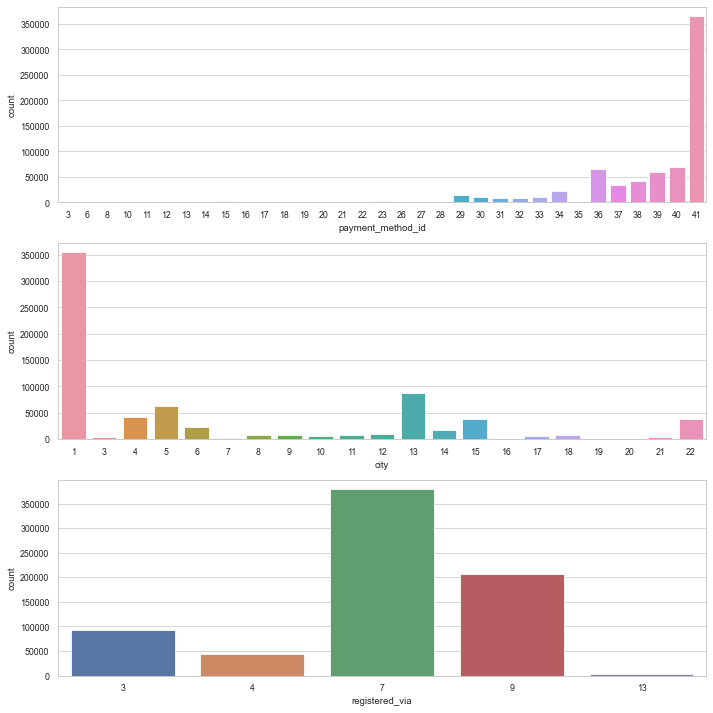

In [238]:
# make bars charts to see the distributions of payment_method_id, city, and registered_via
cat_features = ["payment_method_id", "city", "registered_via"]
sns.set_context("paper")
fig, axs = plt.subplots(3, 1, figsize=(10,10))
for i, feature in enumerate(cat_features):
    sns.countplot(x=feature, data=full_pd_df, ax=axs[i]);
fig.tight_layout()

#### 1.4.1.4 Numerical Columns<a id="Numerical_Columns"></a>

Here we will deal with the age column from the members data, as well as:

These columns from the transactions data:
* payment_plan_days        
* plan_list_price           
* actual_amount_paid 

And these columns from the listening data:
* total_days                
* total_num_25              
* total_num_50              
* total_num_75              
* total_num_985             
* total_num_100             
* total_num_unique          
* total_secs

Let's drop any negative values and values greater than 100.

In [283]:
sum(full_pd_df.age < 0)

52

In [284]:
sum(full_pd_df.age > 100)

386

In [285]:
full_pd_df = full_pd_df[(full_pd_df.age <= 100) & (full_pd_df.age >= 0)]

In [286]:
#summary stats of age column
full_pd_df.age.describe()

count    725284.000000
mean         14.052195
std          16.035292
min           0.000000
25%           0.000000
50%           0.000000
75%          28.000000
max         100.000000
Name: age, dtype: float64

The median is 0, which is unreasonable. Let's see exactly how many values are 0:

In [287]:
sum(full_pd_df.age == 0)

383225

There's obviously an error here. Let's find the interquartile range for the ages without the 0s, and replace the 0s with ages randomly chosen from that range. 

In [288]:
age_series = full_pd_df.age.copy()
no_zeros = age_series[age_series!=0]
quartile_25 = no_zeros.describe()["25%"]
quartile_75 = no_zeros.describe()["75%"]
print("25th quartile:", quartile_25)
print("75th quartile:", quartile_75)

25th quartile: 24.0
75th quartile: 34.0


In [289]:
i = 0
while i < len(age_series):
    if age_series.iloc[i] == 0:
        age_series.iloc[i] = np.random.randint(quartile_25, quartile_75)
    i+=1

age_series.describe()

count    725284.000000
mean         29.110973
std           6.378405
min           1.000000
25%          25.000000
50%          28.000000
75%          32.000000
max         100.000000
Name: age, dtype: float64

These are much more reasonable summary satistics. Now, let's take a look at the boxplot again, with our changes:

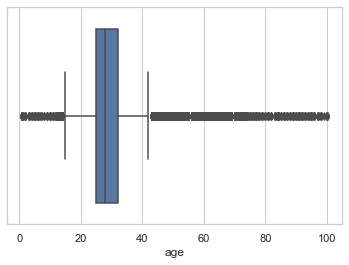

In [290]:
full_pd_df["age"] = age_series

# Boxplot of age column
sns.set_theme(style="whitegrid")
sns.boxplot(x=full_pd_df["age"]);

Now, let's take a look at the "payment_plan_days" column. 

In [291]:
full_pd_df.payment_plan_days.describe()

count    725284.000000
mean         34.976406
std          37.577405
min           1.000000
25%          30.000000
50%          30.000000
75%          30.000000
max         450.000000
Name: payment_plan_days, dtype: float64

As stated in the context, the majority of the subscriptions last 30 days.  

Now let's take a look at "plan_list_price" and "actual_amount_paid":

In [292]:
full_pd_df.plan_list_price.describe()

count    725284.000000
mean        153.715648
std         157.287474
min           0.000000
25%          99.000000
50%         149.000000
75%         149.000000
max        2000.000000
Name: plan_list_price, dtype: float64

In [293]:
full_pd_df.actual_amount_paid.describe()

count    725284.000000
mean        153.498439
std         157.380108
min           0.000000
25%          99.000000
50%         149.000000
75%         149.000000
max        2000.000000
Name: actual_amount_paid, dtype: float64

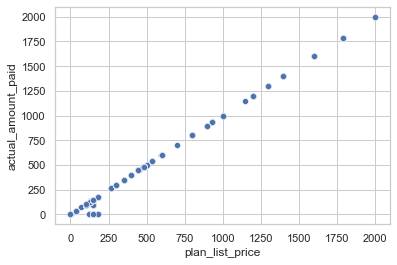

In [294]:
sns.scatterplot(x="plan_list_price", y="actual_amount_paid", data=full_pd_df);

There are a few customers who got a discount, but the overwhelming majority paid the listed price. 

Let's fix any rows where a customer payed more than the listed price. Then, we will isolate those who got a discount. 

In [295]:
paid_more = full_pd_df[full_pd_df.actual_amount_paid > full_pd_df.plan_list_price]
paid_more

,msno,transaction_date,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,membership_expire_date,is_cancel,...,registered_via,registration_init_time,total_days,total_num_25,total_num_50,total_num_75,total_num_985,total_num_100,total_num_unique,total_secs
6731,45UpnCjLzdXmZx6QtGiiylUb6bdaBzwg2UXwukwotrw=,20151209,1,38,30,126,127,0,20170515,0,...,9,20140712,25,111,24,13,17,412,520,116931.92
18099,IC9SswMka7S1+iCPxMjxb9S/cwR1LWdPotaDhrqKxXo=,20151225,1,38,30,126,127,0,20200420,0,...,9,20100513,24,31,63,28,12,477,580,116087.23


In [297]:
# Fix these two rows
aap_index = list(full_pd_df.columns).index("actual_amount_paid")
plp_index = list(full_pd_df.columns).index("plan_list_price")
full_pd_df = full_pd_df.set_index("msno")

for _, row in paid_more.iterrows():   
    full_pd_df.loc[row.msno, "actual_amount_paid"] = full_pd_df.loc[row.msno, "plan_list_price"]
    
full_pd_df = full_pd_df.reset_index()

# Confirm the fix worked 
assert((full_pd_df.actual_amount_paid <= full_pd_df.plan_list_price).all())

In [298]:
# Isolate discounts
discounts = full_pd_df[full_pd_df.actual_amount_paid < full_pd_df.plan_list_price]
len(discounts)

1531

In [299]:
discounts.head()

,msno,transaction_date,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,membership_expire_date,is_cancel,...,registered_via,registration_init_time,total_days,total_num_25,total_num_50,total_num_75,total_num_985,total_num_100,total_num_unique,total_secs
39,+14H1v78CHVFv9RX3XusVZEj4f+YwWe3ozVjoUZSaVM=,20170311,1,40,30,149,0,1,20170410,0,...,3,20131022,22,89,2,13,8,666,623,167080.387
609,+XmR82SLjPmqoj5Sp4O5iYPi/fCXqCG6ukLuV2uhD/U=,20170331,0,23,30,149,129,1,20170430,0,...,9,20160722,25,80,75,53,31,2447,2559,580789.357
664,+bnloTuHJ2gPzQ7UW4U8m0ByGyeP2h1Y89PLmJARWy8=,20170331,0,23,30,149,99,1,20170430,0,...,9,20170328,1,0,2,0,0,17,16,3791.731
2832,0YbDVKt6f4gFErOCWwePLy8MtbXy5/FirURKcgwjWSI=,20170326,1,40,30,149,0,1,20170425,0,...,9,20061209,25,143,27,20,25,407,288,109516.541
3188,0sXpu6bW+cTdYZPtwZFOhiWwuahUnjmsFiX41e02UQI=,20170331,0,23,30,149,99,1,20170506,0,...,9,20161018,27,147,19,13,21,394,497,110410.563


Just from looking at the first five rows, we can observe that some customers churned even though they got a discount. Let's graph the is_churn column for discounts to get a more complete picture: 

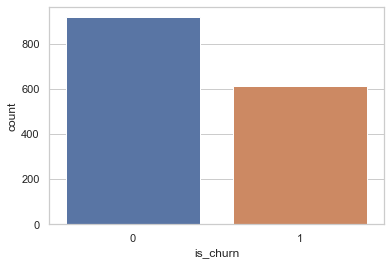

In [300]:
sns.countplot(x="is_churn", data=discounts);

So discounts may have some effect on whether or not a customer churns, as more customers with discounts kept their subscriptions than those that cancelled. 

Let's remove outliers from user listening data, then visualise using boxplots:

In [301]:
def drop_outliers(df, columns, n=3):
    """ 
    Given a dataframe and a list of columns, drop any rows in those columns that 
    have values greater than n standard deviations from the mean
    
    Parameters:
        df:      a dataframe
        columns: columns to check for outliers
        n:       number of standard deviations from the mean
        
    Returns dataframe with outliers removed 
    """
    for col in columns:
        df = df[df[col] < df[col].mean()+(df[col].std()*n)]
    return df

In [302]:
user_logs_features = ["total_days", "total_num_25", "total_num_50", 
                "total_num_75", "total_num_985", "total_num_100", "total_num_unique", "total_secs"]
full_pd_df = drop_outliers(full_pd_df, user_logs_features)

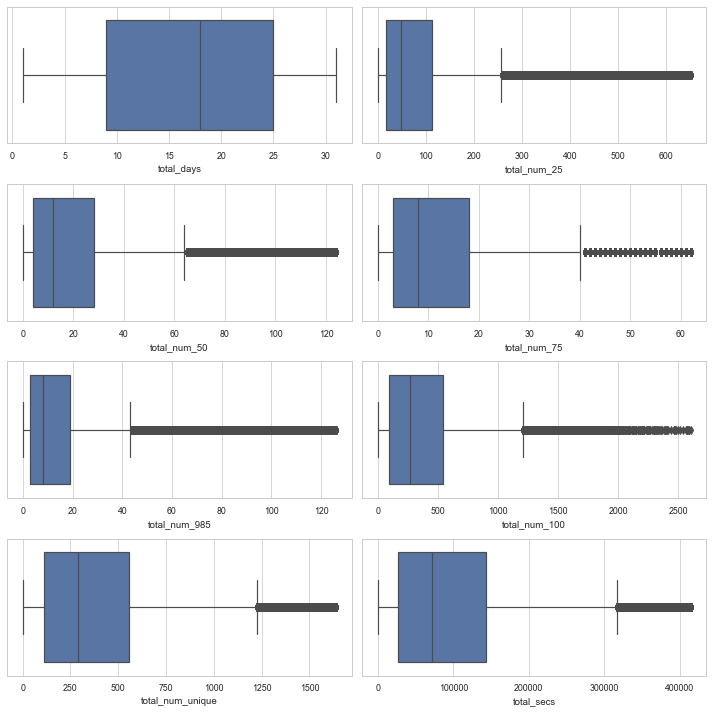

In [303]:
# Make boxplots to see the distributions for each of the features from user listening data
sns.set_context("paper")
fig, axs = plt.subplots(4, 2, figsize=(10,10))
axs = axs.flatten()
for i, feature in enumerate(user_logs_features):
    sns.boxplot(x=feature, data=full_pd_df, ax=axs[i]);
fig.tight_layout()